## 使用 RAG 和自我修正进行代码生成

代码生成的难题与普通的自然语言处理不同————它们涉及严格遵循目标编程语言的语法规则、识别正常和边界情况、关注问题规范中的众多细节，并应对代码特有的其他问题和需求。因此，自然语言生成领域的许多常用优化技巧对代码生成任务来说可能并不适用。

[这项研究](https://arxiv.org/pdf/2401.08500)提出了一种全新的代码生成方法，名为AlphaCodium，这是一种基于测试、分阶段、专注于代码的迭代处理流程。通过这种方法显著提升了大语言模型(LLM)在处理代码问题上的能力。

在验证数据集上，使用 AlphaCodium 流程后，GPT-4 的准确率（pass@5）从单一精心设计的直接提示的 19% 提升到了 44%。AlphaCodium 在性能上不仅超越了之前的研究成果，如 AlphaCode，而且所需的计算资源也大大减少。

AlphaCodium 提出了一种使用控制流进行代码生成的方法。

主要思想：迭代地构建对编码问题的答案。

AlphaCodium 迭代地测试和改进针对特定问题的公共和 AI 生成的测试的答案。

我们将使用 LangGraph 从头开始实施这些想法中的部分内容。
- 我们从用户指定的一组文档开始。
- 我们使用长上下文 LLM 来摄取它并执行 RAG 以根据它回答问题。
- 我们将调用一个工具来生成结构化的输出。
- 在将解决方案返回给用户之前，我们将执行两个单元测试（检查导入和代码执行）。

<img src="images/code-generation-langgraph.png" alt="code-generation-langgraph" width="80%"><br>


首先，让我们安装所需的包并设置我们将需要的 API 密钥。

In [1]:
# ! pip install -U langchain_community langchain-openai langchain langgraph bs4

In [21]:
import dotenv
import os
dotenv.load_dotenv('../.env')

True

加载 LangChain 表达式语言 (LCEL) 文档作为示例。

In [22]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL 文档
url = "https://python.langchain.ac.cn/docs/concepts/#langchain-expression-language-lcel"
#将网页中的所有链接都导入
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# 根据URL对列表进行排序并获取文本
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

下面使用gpt-4o-mini创建一个code_gen_chain，要求gpt-4o-mini生成一段LCEL的代码

In [23]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

#生成代码的prompt
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is a full set of LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user 
    question based on the above provided documentation. Ensure any code you provide can be executed \n 
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:""",
# """
# 您是一位擅长LCEL（LangChain表达式语言）的编程助手。\n
# 以下是一整套LCEL文档：\n ------- \n  {context} \n ------- \n 请根据上述提供的文档回答用户的问题。确保您提供的任何代码都能够被执行，\n
# 并定义所有必需的导入和变量。请以代码解决方案的描述开始您的回答。\n
# 然后列出导入的库。最后列出功能性的代码块。以下是用户的问题：
# """
        ),
        ("placeholder", "{messages}"),
    ]
)


#生成代码的数据格式
class code(BaseModel):
    """Schema for code solutions to questions about LCEL."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    # prefix: str = Field(description="问题的描述和解决方法")
    # imports: str = Field(description="代码块导入语句")
    # code: str = Field(description="不包括导入语句的代码块")


expt_llm = "gpt-4o"
llm = ChatOpenAI(temperature=0, model=expt_llm)
code_gen_chain_oai = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a RAG chain in LCEL?"
# question = "我要如何构建一个LCEL的RAG链"

solution = code_gen_chain_oai.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
solution

code(prefix="To build a Retrieval-Augmented Generation (RAG) chain in LangChain Expression Language (LCEL), you need to combine a language model with a retrieval component. The retrieval component fetches relevant documents from a knowledge base, which are then used by the language model to generate more informed responses. This process enhances the language model's capabilities by providing it with external knowledge. Below is a basic example of how you can set up a RAG chain using LCEL.", imports='from langchain_core import LLM, Retriever, RAGChain\nfrom langchain_core.retrievers import SimpleRetriever\nfrom langchain_core.llms import OpenAI\nfrom langchain_core.chains import RAGChain', code='# Initialize the language model\nllm = OpenAI(api_key="your_openai_api_key")\n\n# Initialize the retriever\nretriever = SimpleRetriever(\n    index_path="path_to_your_index",\n    embedding_model="your_embedding_model"\n)\n\n# Create the RAG chain\nrag_chain = RAGChain(\n    llm=llm,\n    retrie

将上述生成的代码拿下来运行（可能每次生成不完全一致，需要根据实际情况进行调整）

In [24]:
from langchain import LLMChain, RetrievalQA
from langchain.llms import OpenAI
from langchain.retrievers import SimpleRetriever


ImportError: cannot import name 'RetrievalQA' from 'langchain' (/home/ubuntu/anaconda3/envs/notebook/lib/python3.10/site-packages/langchain/__init__.py)

可以看出生成的代码并不能直接使用，这与langchain更新较快或gpt-4o-mini的模型规模较小有一定的关系，虽然有参考文本，但仍然会很容易地生成过时或错误的代码。

下面使用langgraph构建一个流程来解决这个问题

首先定义状态，状态是一个 dict，它将包含与代码生成相关的键（错误、问题、代码生成）。

In [25]:
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

定义结点和边，以及循环次数和是否反馈

In [26]:
### Parameter

# Max tries
max_iterations = 20
# Reflect
flag = 'reflect'
# flag = "do not reflect"

### Nodes


def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain_oai.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain_oai.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    print(reflections)
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

定义工作流

In [27]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

画出来看一下

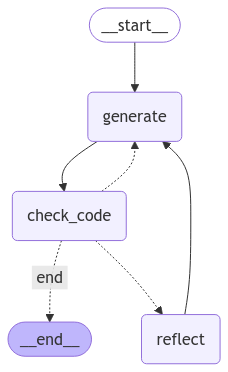

In [28]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

测试

In [29]:
question = "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"
# question = "如何直接将一个字符串传递给一个Runnable，并用它来构造我所需的提示输入?"
# question = ""
solution = app.invoke({"messages": [("user", question)], "iterations": 0, "error": "","recursion_limit":40})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
prefix='To directly pass a string to a runnable and use it to construct the input needed for your prompt, you can create a custom runnable class that processes the input string and formats it into a prompt. This involves defining a class that inherits from a base runnable class and implements the necessary logic to handle the input string and construct the prompt. Below is an example of how you can achieve this using a simple Python class.' imports='from langchain_core.runnables import Runnable' code='class StringToPromptRunnable(Runnable):\n    def __init__(self, prompt_template):\n        self.prompt_template = prompt_template\n\n    def invoke(self, input_string):\n        # Process the input string to construct the prompt\n        prompt_input = self.process_input(input_string)\n        # Construct the prompt using the template\n        p

In [30]:
solution["generation"]

code(prefix='To directly pass a string to a runnable and use it to construct the input needed for your prompt, you can create a custom runnable class that processes the input string and formats it into a prompt. This involves defining a class that inherits from a base runnable class and implements the necessary logic to handle the input string and construct the prompt. Below is an example of how you can achieve this using a simple Python class.', imports='from langchain_core.runnables import Runnable', code='class StringToPromptRunnable(Runnable):\n    def __init__(self, prompt_template):\n        self.prompt_template = prompt_template\n\n    def invoke(self, input_string):\n        # Process the input string to construct the prompt\n        prompt_input = self.process_input(input_string)\n        # Construct the prompt using the template\n        prompt = self.prompt_template.format(input=prompt_input)\n        return prompt\n\n    def process_input(self, input_string):\n        # Exa

In [31]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage

# Create an instance of the ChatOpenAI language model
llm = ChatOpenAI(model='gpt-3.5-turbo')
# Define a function that formats the input string for the prompt
def string_to_prompt(input_string: str) -> str:
    # Construct the prompt using the input string
    return f"Please summarize the following text: {input_string}"
# Example input string
input_string = "LangChain is a framework for developing applications powered by language models."
# Format the input string to create the prompt
prompt = string_to_prompt(input_string)
# Get the response from the language model
response = llm([HumanMessage(content=prompt)])
# Print the result
print(response.content)

LangChain is a framework designed to create applications that utilize language models.
